In [ ]:
import mutagen
import os
from pathlib import Path
import librosa
import pandas as pd
import warnings
import re
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import cupyx.scipy.fft as cufft
import scipy.fft
import shutil
import glob
import seaborn as sns
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.signal import savgol_filter



In [6]:
current_dir = Path(os.getcwd())
path_to_ffts = current_dir / 'ffts'
if os.path.exists(path_to_ffts):
    print(f"file exists {path_to_ffts}. deleting it.")
    shutil.rmtree(path_to_ffts)


feather = pd.read_feather('output_dataset_with_amp_uri.feather')
os.makedirs("ffts", exist_ok=True)
for _, track in feather.iterrows():
    track_amp_uri = feather.loc[_, 'amp_path']
    track_sr = int(feather.loc[_, 'sampling_rate'])

    fs = track_sr
    x = np.load(track_amp_uri)
    t = fs * len(x)

    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(len(x), 1/fs)

    uri__fft_path = f"ffts/{_}_fft.npy"

    np.save(uri__fft_path, X)



In [ ]:
file_path = 'output_dataset_with_amp_uri.feather'

df = pd.read_feather(file_path)

print(df.head())

df.to_csv('output_dataset_with_amp_uri_for_debug.csv', index=False)

   energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.561  150.069         0.669            pop    -6.538    0.0954    0.841   
1   0.806  104.032         0.608            pop    -3.443    0.1910    0.587   
2   0.917  100.987         0.562            pop    -2.768    0.4880    0.501   
3   0.787  109.939         0.734            pop    -3.951    0.3120    0.672   
4   0.843  122.064         0.619            pop    -5.348    0.1640    0.746   

    track_artist  time_signature  speechiness  ...  instrumentalness mode key  \
0    Addison Rae               4       0.0411  ...          0.009620    1  10   
1     Tate McRae               4       0.0486  ...          0.000000    1   1   
2      Lady Gaga               4       0.1170  ...          0.000000    0  11   
3           LISA               4       0.1160  ...          0.000000    0   5   
4  Morgan Wallen               4       0.0284  ...          0.000118    0   5   

  acousticness                  

C:\Users\grzto\AppData\Local\Temp\ipykernel_31188\4249371464.py:39: RuntimeWarning: invalid value encountered in log1p
  M_log = np.log1p(M_sorted * 50)  # mnożnik poprawia kontrast


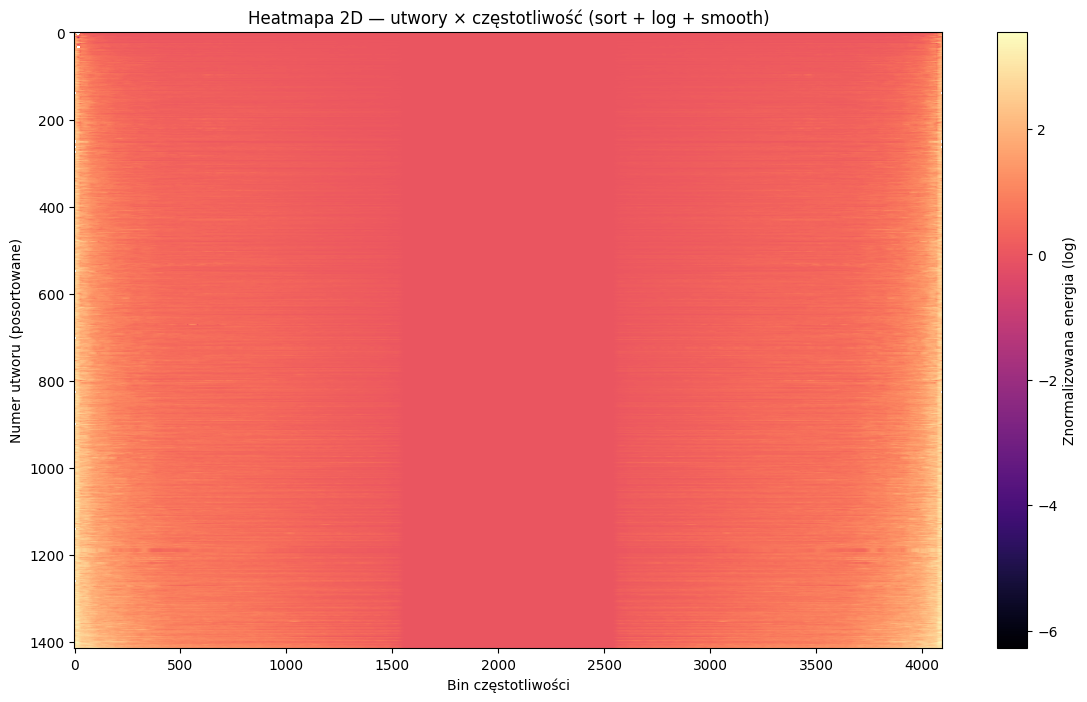

In [ ]:
fft_files = glob.glob("ffts/*.npy")

N = 4096  
num_tracks = len(fft_files)

M = np.zeros((num_tracks, N), dtype=np.float32)

for i, f in enumerate(fft_files):
    X = np.load(f, mmap_mode="r")
    mag = np.abs(X)

    mag_res = np.interp(
        np.linspace(0, len(mag)-1, N),
        np.arange(len(mag)),
        mag
    )

    mag_res /= mag_res.max()

    mag_res = savgol_filter(mag_res, window_length=51, polyorder=3)

    M[i] = mag_res.astype(np.float32)

centroids = M.mean(axis=1)
order = np.argsort(centroids)
M_sorted = M[order]

M_log = np.log1p(M_sorted * 50)

plt.figure(figsize=(14, 8))
plt.imshow(M_log, aspect='auto', cmap='magma')
plt.colorbar(label="Normalized energy (log)")
plt.title("2D Heatmap — tracks × frequency (sort + log + smooth)")
plt.xlabel("Frequency bin")
plt.ylabel("Track number (sorted)")
plt.show()


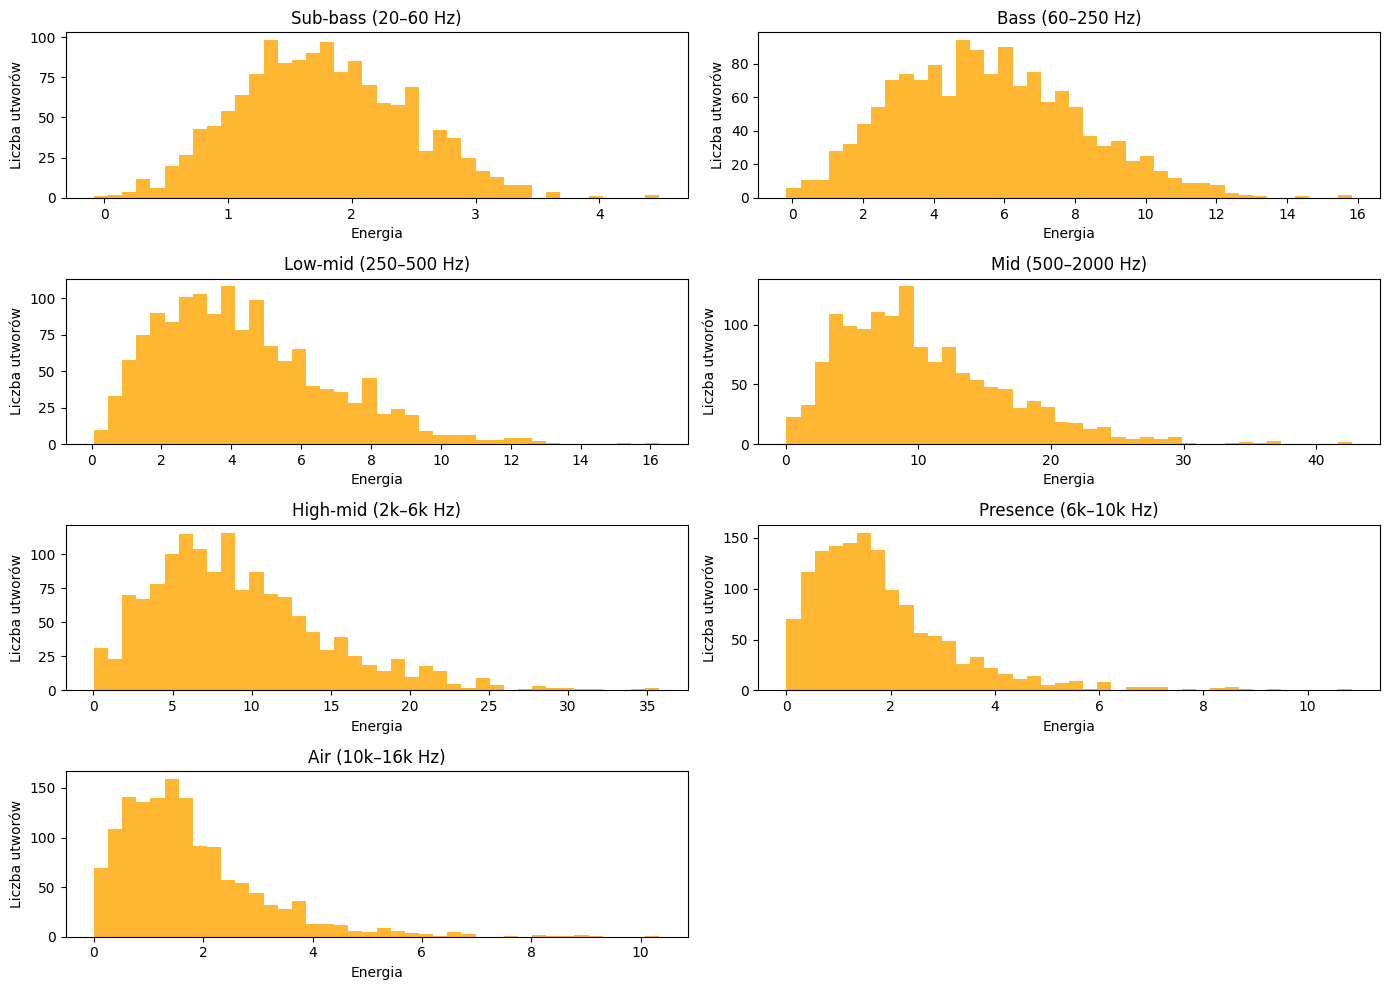

In [ ]:
fs = 44100
N = M.shape[1]

freqs = np.linspace(0, fs/2, N)

bands = {
    "Sub-bass (20–60 Hz)": (20, 60),
    "Bass (60–250 Hz)": (60, 250),
    "Low-mid (250–500 Hz)": (250, 500),
    "Mid (500–2000 Hz)": (500, 2000),
    "High-mid (2k–6k Hz)": (2000, 6000),
    "Presence (6k–10k Hz)": (6000, 10000),
    "Air (10k–16k Hz)": (10000, 16000),
}

energies = {}

for name, (f_low, f_high) in bands.items():
    idx = np.where((freqs >= f_low) & (freqs < f_high))[0]
    band_energy = M[:, idx].sum(axis=1)
    energies[name] = band_energy

plt.figure(figsize=(14, 10))

for i, (name, vals) in enumerate(energies.items()):
    plt.subplot(4, 2, i+1)
    plt.hist(vals, bins=40, color="orange", alpha=0.8)
    plt.title(name)
    plt.xlabel("Energy")
    plt.ylabel("Songs number")

plt.tight_layout()
plt.show()


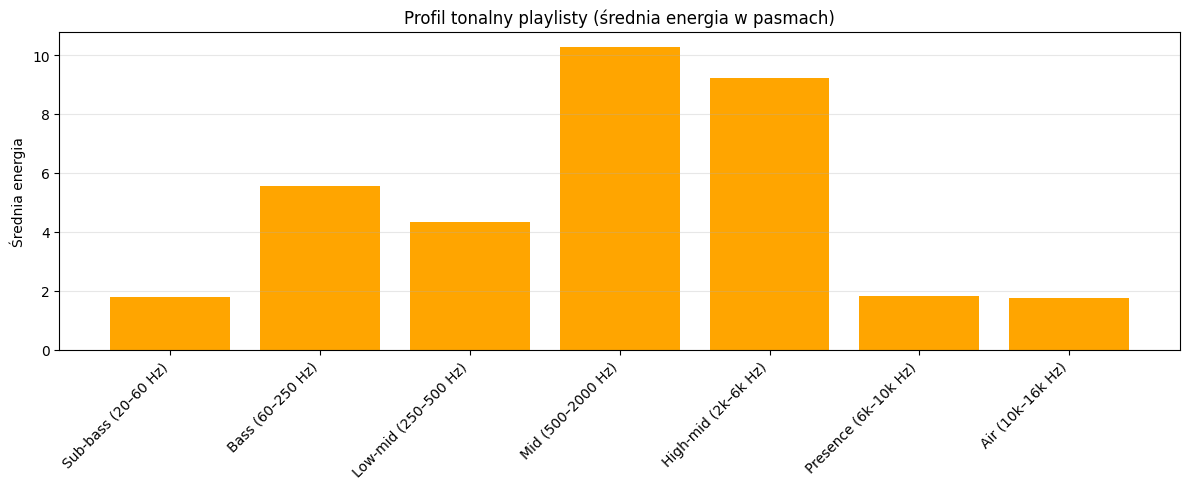

In [ ]:
mean_band_energy = {}

for name, (f_low, f_high) in bands.items():
    idx = np.where((freqs >= f_low) & (freqs < f_high))[0]
    band_energy = M[:, idx].sum(axis=1)
    mean_band_energy[name] = band_energy.mean()

plt.figure(figsize=(12, 5))
plt.bar(mean_band_energy.keys(), mean_band_energy.values(), color="orange")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Energy")
plt.title("Tonal profile of the playlist (average energy across bands)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


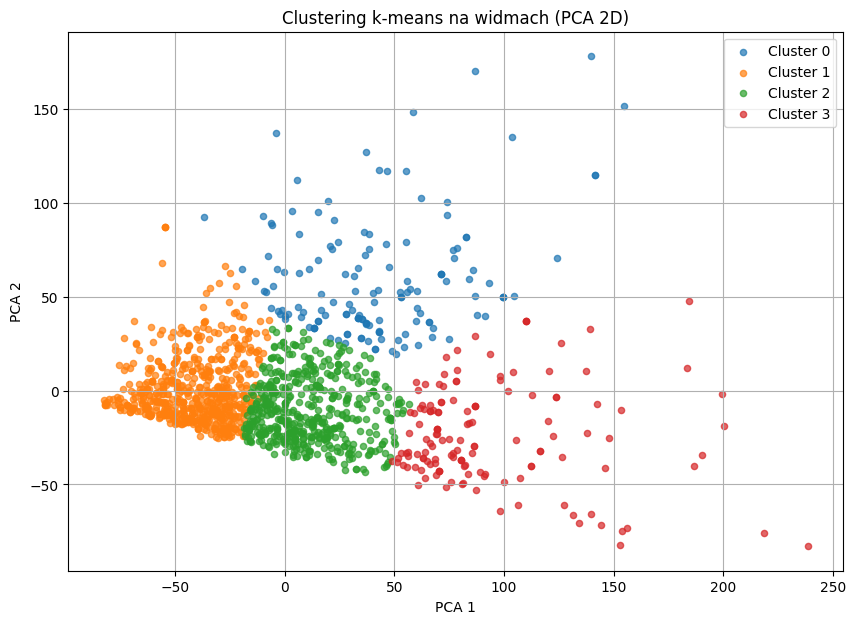

In [ ]:
scaler = StandardScaler()
M_scaled = scaler.fit_transform(M)

pca = PCA(n_components=50, random_state=0)
M_pca = pca.fit_transform(M_scaled)

k = 4
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
labels = kmeans.fit_predict(M_pca)

pca2 = PCA(n_components=2, random_state=0)
M_2d = pca2.fit_transform(M_pca)

plt.figure(figsize=(10, 7))
for cluster_id in range(k):
    idx = labels == cluster_id
    plt.scatter(M_2d[idx, 0], M_2d[idx, 1], s=20, alpha=0.7, label=f"Cluster {cluster_id}")

plt.title("Clustering k-means na widmach (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()
